# 1. Загрузка и предобработка

In [57]:
from sklearn.datasets import fetch_20newsgroups
import re
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections



In [58]:
train = fetch_20newsgroups(data_home="./",subset='train',shuffle=True, random_state=42)
test = fetch_20newsgroups(data_home="./",subset='test',shuffle=True, random_state=42)

In [59]:
"""
Функция поиска первой строки сообщения
"""
def get_text_idx(text:str):
    idx,_ = next(
        line for line in enumerate(
            text.split('\n')
        ) 
        if not line[1]
    )
    return idx+1

In [60]:
"""
Класс получения индекса первого совпадения
с регулярным выражением
"""
class RegFindIdx:
    def __init__(self,re_sign):
        self.regexp = re_sign
    def get_re_idx(self,text):
        result = self.regexp.search(text)
        return result.start() if not result is None else result

In [61]:
"""
Подпись 1 типа
"""
sign_1_type = RegFindIdx(re.compile(r'^-[\n]*.*',re.MULTILINE))
"""
цитаты
"""
quote = re.compile(r">.+")

In [62]:
from sklearn.base import BaseEstimator,TransformerMixin

In [63]:
class RemoveHeader(BaseEstimator, TransformerMixin):
    def transform_one_line(self,line):
        text_idx = get_text_idx(line)
        return "\n".join(line.split('\n')[text_idx:])
    
    def fit_transform(self,X, y=None, **fit_params):
        if len(X[0])==1:
            return self.transform_one_line(X)
        return list(
            map(lambda x: self.transform_one_line(x),X)
        )
    
class RemoveSig1(BaseEstimator, TransformerMixin):
    def transform_one_line(self,line):
        sign_idx = sign_1_type.get_re_idx(line)
        if not sign_idx is None:
            line = line[:sign_idx]
        return line
    
    def fit_transform(self,X, y=None, **fit_params):
        if len(X[0])==1:
            return self.transform_one_line(X)
        return list(
            map(lambda x: self.transform_one_line(x),X)
        )
class RemoveQuote(BaseEstimator, TransformerMixin):
    def transform_one_line(self,line):
        line = quote.sub('',line)
        return line    
    def fit_transform(self,X, y=None, **fit_params):
        if len(X[0])==1:
            return self.transform_one_line(X)
        return list(
            map(lambda x: self.transform_one_line(x),X)
        )
class Lower(BaseEstimator, TransformerMixin):
    def transform_one_line(self,line):
        line = line.lower()
        return line
    
    def fit_transform(self,X, y=None, **fit_params):
        if len(X[0])==1:
            return self.transform_one_line(X)
        return list(
            map(lambda x: self.transform_one_line(x),X)
        )
class DropSpecChar(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.reg1 = re.compile(r'\W')
        self.reg2 = re.compile(r'[ ]{2,}')
    def transform_one_line(self,line):
        line = self.reg1.sub(' ',line)
        line = self.reg2.sub(' ',line) 
        return line
    
    def fit_transform(self,X, y=None, **fit_params):
        if len(X[0])==1:
            return self.transform_one_line(X)
        return list(
            map(lambda x: self.transform_one_line(x),X)
        )

In [64]:
"""
Пайплайн трансформаций
"""
class Macro:
    def __init__(self):
        self.commands = []
    def add(self, command):
        self.commands.append(command)
    def run(self,msg):
        for c in self.commands:
            msg=c.fit_transform(msg)
        return msg

In [65]:
macro = Macro()
macro.add(RemoveHeader())
macro.add(RemoveSig1())
macro.add(RemoveQuote())
macro.add(Lower())
macro.add(DropSpecChar())

In [66]:
X_train_raw,y_train,X_test_raw,y_test = train.data,train.target,\
test.data,test.target

#### Применим предобработку данных к тренировочной и тестовым выборкам.

In [67]:
import pickle

In [68]:
X_train,X_test=macro.run(X_train_raw),macro.run(X_test_raw)

In [69]:
with open("X_train","wb") as f:
    pickle.dump(X_train,f)
with open("X_test","wb") as f:
    pickle.dump(X_train,f)

# 2. Применение CountVectorizer и TfidfVectorizer

#### Посмотрим на диаграммы количества различных классов, на обучающей и тестовой выборках, проверим являются ли выборки сбалансированными.

In [70]:
train_labels = pd.DataFrame({'target':train.target})
test_labels = pd.DataFrame({'target':test.target})

In [71]:
train_counts=train_labels['target'].value_counts()
test_counts=test_labels['target'].value_counts()

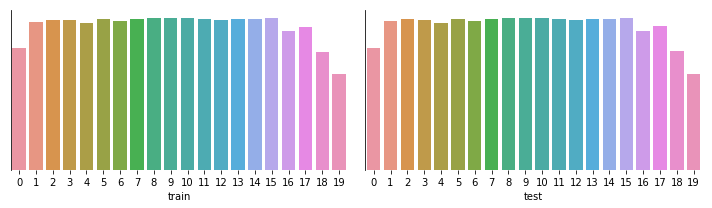

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3), sharex=True)
sns.barplot(x=train_counts.index, y=train_counts.values,ax=axes[0])
axes[0].set_xlabel("train")
sns.barplot(x=test_counts.index, y=test_counts.values,ax=axes[1])
axes[1].set_xlabel("test")
sns.despine(bottom=True)
plt.setp(fig.axes, yticks=[])
plt.tight_layout(h_pad=2)

####  из диаграм видно, что все классы сбалансированы и нет необходимости применять стратификацию.

#### Преобразуем датасет с помощью count vectorizer 

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

In [74]:
train_size, test_size = len(X_train),len(X_test)

In [75]:
%%time
X_vec = vectorizer.fit_transform(X_train+X_test)
X_train_vec = X_vec[:train_size]
X_test_vec = X_vec[train_size:]

CPU times: user 3.13 s, sys: 43.9 ms, total: 3.17 s
Wall time: 3.14 s


In [76]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

In [77]:
svm = SGDClassifier()

In [78]:
scores = cross_val_score(svm,X_train_vec,y_train,cv=5)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [79]:
print(scores,np.mean(scores))

[0.65138828 0.67299206 0.64487633 0.59690265 0.60221729] 0.6336753216233858


#### Преобразуем датасет с помощью tf-idf

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vec = TfidfVectorizer()

In [81]:
%%time
X_tf = tf_idf_vec.fit_transform(X_train+X_test)
X_train_tf = X_tf[:train_size]
X_test_tf = X_tf[train_size:]

CPU times: user 4.39 s, sys: 7.3 ms, total: 4.4 s
Wall time: 4.45 s


In [82]:
tf_idf_vocab = list(tf_idf_vec.vocabulary_.items())

In [83]:
len(tf_idf_vocab)

110233

In [84]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

In [85]:
svm = SGDClassifier()

In [86]:
scores = cross_val_score(svm,X_train_tf,y_train,cv=5)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [87]:
print(scores,np.mean(scores))

[0.80431908 0.809797   0.81404594 0.81681416 0.81019956] 0.8110351469285618


#### Вывод
Преобразование `TfidfVectorizer`  лучше на валидационной выборке, чем `CountVectorizer`(классификатор svm ошибается на 17% меньше), время работы приблизительно одинаковое.

#### Проверка та тестовой выборке.

In [88]:
from sklearn.metrics import accuracy_score

In [89]:
svm = SGDClassifier()

In [90]:
svm.fit(X_train_tf,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [91]:
pred=svm.predict(X_test_tf)

In [92]:
acc = accuracy_score(pred,y_test)
print(acc)

0.7391131173659055


In [93]:
test_df=pd.DataFrame({'pred':pred,'y':y_test,'msg':X_test})

In [94]:
test_df['pred_theme']=test_df['pred'].apply(lambda x: test.target_names[x])
test_df['y_theme']=test_df['y'].apply(lambda x: test.target_names[x])

In [95]:
wrond_ans = test_df[test_df.pred!=test_df.y]

In [96]:
wrond_ans[:100]

pred            ...                              y_theme
1       1            ...                       comp.windows.x
4       0            ...                   talk.religion.misc
6      10            ...               soc.religion.christian
7       2            ...               soc.religion.christian
11      1            ...                       comp.windows.x
14     15            ...                          alt.atheism
15      3            ...              comp.os.ms-windows.misc
16      2            ...                comp.sys.mac.hardware
17     12            ...                        comp.graphics
20     13            ...                        comp.graphics
29     14            ...             comp.sys.ibm.pc.hardware
32      1            ...                comp.sys.mac.hardware
35      5            ...                        comp.graphics
38      4            ...                         misc.forsale
41      6            ...              comp.os.ms-windows.misc
45      9            ...                        comp.graphics
47      0            ...             comp.sys.ibm.pc.hardware
49     11            ...                          alt.atheism
55     19            ...              comp.os.ms-windows.misc
62      8            ...                talk.politics.mideast
63      6            ...                   talk.religion.misc
71      6            ...                   talk.politics.misc
76     19            ...                   talk.politics.misc
81      9            ...                   talk.politics.misc
89      3            ...                comp.sys.mac.hardware
90      1            ...                            sci.space
94      2            ...                   talk.politics.guns
95     11            ...                          alt.atheism
97      1            ...             comp.sys.ibm.pc.hardware
98      2            ...             comp.sys.ibm.pc.hardware
..    ...            ...                                  ...
259     4            ...                            sci.crypt
261     2            ...                        comp.graphics
267     1            ...              comp.os.ms-windows.misc
272    16            ...                   talk.politics.misc
279     1            ...             comp.sys.ibm.pc.hardware
287    13            ...                   talk.religion.misc
293     8            ...                            rec.autos
294     7            ...               soc.religion.christian
296    18            ...                      rec.motorcycles
302    19            ...               soc.religion.christian
307    18            ...                            rec.autos
311     4            ...                         misc.forsale
316    17            ...                          alt.atheism
317    13            ...                      rec.motorcycles
319    13            ...              comp.os.ms-windows.misc
322    13            ...                comp.sys.mac.hardware
325    14            ...                   talk.politics.misc
326    16            ...                   talk.politics.misc
330    16            ...                   talk.religion.misc
332     1            ...                comp.sys.mac.hardware
337     5            ...                            sci.crypt
344     1            ...                              sci.med
349     6            ...                comp.sys.mac.hardware
350    11            ...                      sci.electronics
351    16            ...                   talk.politics.misc
358     2            ...                       comp.windows.x
364     2            ...                       comp.windows.x
372     1            ...                comp.sys.mac.hardware
377    18            ...                talk.politics.mideast
380     5            ...                      sci.electronics

[100 rows x 5 columns]

Алогритм ошибается на схожих темах, например (`alt.atheism`,`talk.religion.misc`), (`comp.graphics`,`comp.windows.x`), потому что в данных темах используются одинаковые наборы слов. Но так же есть случаи, в которых алгоритм ошибается и предсказывает не схожую тематику.


From: dan@igate.c-mols.siu.edu (Dan Ellison)
Subject: Re: Scientific graphing - looking for run-time library
Organization: Southern Illinois University - Carbondale, IL (SIU-C)
Distribution: usa
Lines: 27

In <1993May10.212110.3980@serval.net.wsu.edu> d3e758@bucky.pnl.gov (JE Pelkey) writes:


>In article <C6IEM6.16xI@hawnews.watson.ibm.com> artg@watson.ibm.com (Art Goldberg) writes:
>>X gurus:
>>I am looking for a scientific graphing run-time X library.  I want my code
>>to open a window, and plot a graph in the window.  The library should
>>manage plotting, scaling of axes, labeling, etc.
>>
>>Can someone recommend a library to do this?  Please respond via e-mail.

>I would also be interested in this information.

Check into the vopl and vogle libraries.  I beleive that I still have
them available on ftp.c-mols.siu.edu but I'm not sure.  I haven't seen
any new announcements for the software but I'm sure it's still around.

I have used it to do real-time data display and analysis as well as
just for producing graphs after the fact.  It works well and supports
numerous graphics output formats (including X.)  I tried it and liked
it.  YOu may as well.

-- 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
| Dan Ellison, Network Spec 	  -    	Computing Affairs, SIU-C 	| 
| Southern Illinois University 	  - 	Carbondale, IL 62901            |   
| FAX:      (618) 453-3459        -   	PHONE:    (618) 453-6149 	|     

`Был предсказан как текст медецинского содержания.`

In [97]:
from sklearn import metrics

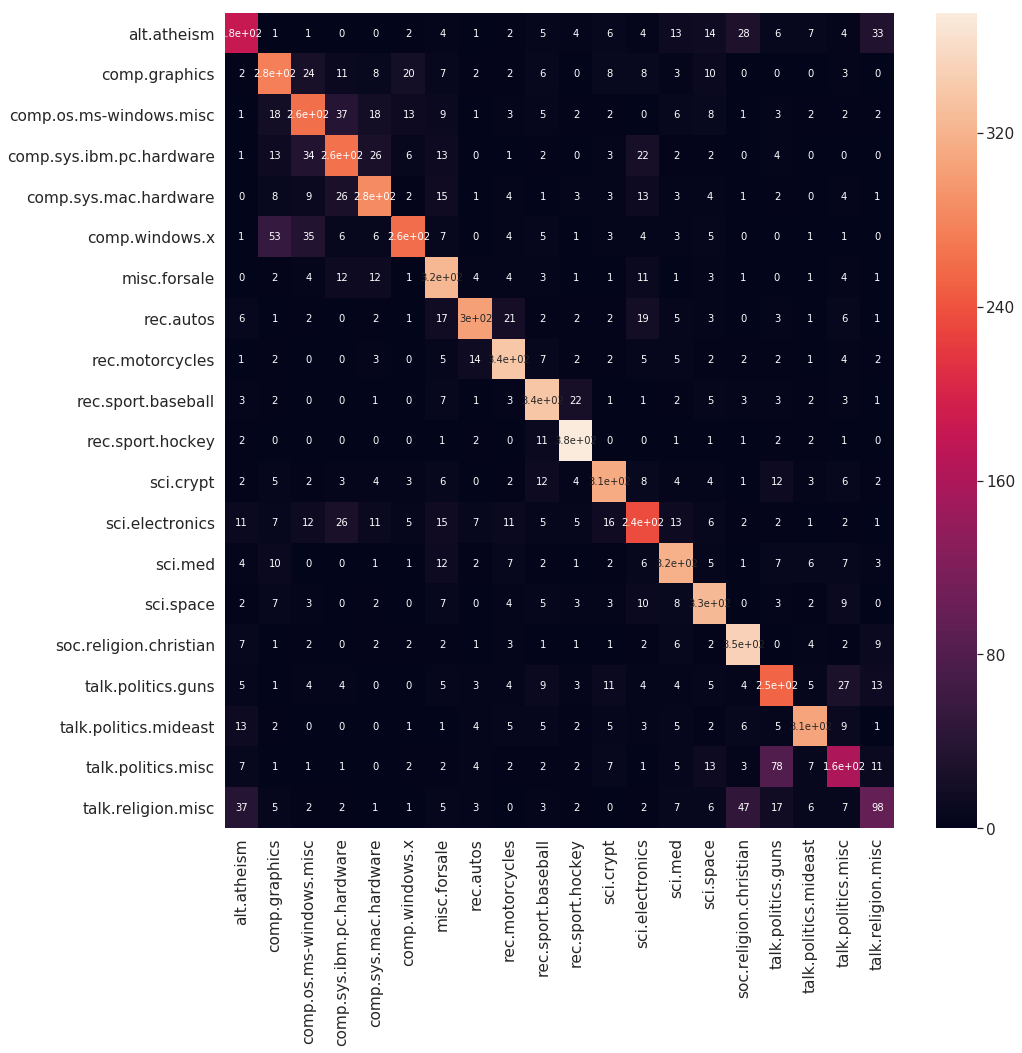

In [98]:
from sklearn.metrics import confusion_matrix

M = confusion_matrix(y_test,pred)
# M_normalized = M.astype('float') / M.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(M, test.target_names,
                  test.target_names)
plt.figure(figsize = (15,15))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 10})# font size

#### Вывод:
По матрице ошибок видно, что больше всего ошибок допущено в темах comp.sys.ibm.pc.hardware, comp.windows.x, talk.politics.misc, talk.politics.guns и хуже всего определяется тема talk.religion.misc.
Ошибочные классификации приходятся на похожие темы.

# 3. Применение стемминга и лемматизации 

### стемлер 

In [99]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [100]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [101]:
stemmed_count_vect = StemmedCountVectorizer()

In [102]:
%%time
X_stm = stemmed_count_vect.fit_transform(X_train+X_test)

CPU times: user 49.4 s, sys: 38.7 ms, total: 49.5 s
Wall time: 49.5 s


In [103]:
X_train_stm, X_test_stm =X_stm[:train_size],X_stm[train_size:]

In [104]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_idf_trf = TfidfTransformer()

In [105]:
%%time
X_stm_train_tf = tf_idf_trf.fit_transform(X_train_stm)
X_stm_test_tf = tf_idf_trf.fit_transform(X_test_stm)

CPU times: user 221 ms, sys: 4.05 ms, total: 225 ms
Wall time: 224 ms


In [106]:
stem_vocab = list(stemmed_count_vect.vocabulary_.items())

In [107]:
print(len(stem_vocab))

90018


In [108]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

svm = SGDClassifier()

In [109]:
scores = cross_val_score(svm,X_stm_train_tf,y_train,cv=5)

print(scores,np.mean(scores))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


[0.81004848 0.80229479 0.8069788  0.81415929 0.80399113] 0.807494498706963


In [110]:
svm.fit(X_stm_train_tf,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [111]:
pred=svm.score(X_stm_test_tf,y_test)

In [112]:
print(pred)

0.735926712692512


### лемматизатор

In [113]:
import tqdm

In [114]:
from nltk import WordNetLemmatizer
from nltk import wordnet, pos_tag

def get_wordnet_pos(treebank_tag):
    my_switch = {
        'J': wordnet.wordnet.ADJ,
        'V': wordnet.wordnet.VERB,
        'N': wordnet.wordnet.NOUN,
        'R': wordnet.wordnet.ADV,
    }
    for key, item in my_switch.items():
        if treebank_tag.startswith(key):
            return item
    return wordnet.wordnet.NOUN
def my_lemmatizer(sent):
    lemmatizer = WordNetLemmatizer()
    tokenized_sent = sent.split()
    pos_tagged = [(word, get_wordnet_pos(tag))
                 for word, tag in pos_tag(tokenized_sent)]
    return ' '.join([lemmatizer.lemmatize(word, tag)
                    for word, tag in pos_tagged])

In [115]:
class LemTransform(BaseEstimator, TransformerMixin):
    def transform_one_line(self,line):
        return my_lemmatizer(line)
    
    def fit_transform(self,X, y=None, **fit_params):
        if len(X[0])==1:
            return self.transform_one_line(X)
        X_trfm = []
        for line in tqdm.tqdm_notebook(X):
            X_trfm.append(self.transform_one_line(line))
        return X_trfm

In [116]:
lemmatizer = LemTransform()

In [117]:
%%time
X_train_lem, X_test_lem = lemmatizer.fit_transform(X_train),lemmatizer.fit_transform(X_test)

CPU times: user 3min 47s, sys: 2.18 s, total: 3min 49s
Wall time: 4min 23s


In [118]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vec = TfidfVectorizer()

In [119]:
%%time
X_tf_lem = tf_idf_vec.fit_transform(X_train_lem+X_test_lem)
X_train_tf_lem = X_tf_lem[:train_size]
X_test_tf_lem = X_tf_lem[train_size:]

CPU times: user 2.82 s, sys: 19.9 ms, total: 2.84 s
Wall time: 2.84 s


In [120]:
lem_vocab = list(tf_idf_vec.vocabulary_.items())

In [121]:
print(len(lem_vocab))

101440


In [122]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

svm = SGDClassifier()

In [123]:
scores = cross_val_score(svm,X_train_tf_lem,y_train,cv=5)

print(scores,np.mean(scores))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


[0.79991186 0.80714916 0.80786219 0.81017699 0.81374723] 0.8077694854611115


In [124]:
svm.fit(X_train_tf_lem,y_train)
pred=svm.score(X_test_tf_lem,y_test)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [125]:
print(pred)

0.7361922464152948


**Вывод:** Применение алгоритмов стемминга и лемматизации не улучшило результаты классификатора на кросс-валидации.

| Алгоритм предобработки | Точность на тестовой<br/> выборке | Размерность признакового<br/> пространства | Время предобработки
| ------ | ----------- | ----------- | -----------|
| без обработки | 0.739 | 110233 | 2c |
| стемминг | 0.737 | 90016 | 2c+30c |
| лемматизация | 0.738 | 101440 | 2c+106c |

# 4. Сокращение словаря.

In [127]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [128]:
lem_vocab.sort(key=lambda x:x[1],reverse=True)
lem_vocab_w=[pair[0] for pair in lem_vocab]

stem_vocab.sort(key=lambda x:x[1],reverse=True)
stem_vocab_w=[pair[0] for pair in stem_vocab]

tf_idf_vocab.sort(key=lambda x:x[1],reverse=True)
tf_idf_vocab_w=[pair[0] for pair in tf_idf_vocab]

In [129]:
def get_acc_lem(num_del):
    tf_idf_vec = TfidfVectorizer(vocabulary=lem_vocab_w[num_del:-num_del])
    X_tf_lem = tf_idf_vec.fit_transform(X_train_lem+X_test_lem)
    X_train_tf_lem = X_tf_lem[:train_size]
    X_test_tf_lem = X_tf_lem[train_size:]
    svm.fit(X_train_tf_lem,y_train)
    acc=svm.score(X_test_tf_lem,y_test)
    return acc
def get_acc_tf(num_del):
    tf_idf_vec = TfidfVectorizer(vocabulary=tf_idf_vocab_w[num_del:-num_del])
    X_tf = tf_idf_vec.fit_transform(X_train+X_test)
    X_train_tf = X_tf[:train_size]
    X_test_tf = X_tf[train_size:]
    svm.fit(X_train_tf,y_train)
    acc=svm.score(X_test_tf,y_test)
    return acc

In [132]:
del_w = np.arange(1,5000,100)
acc_val_lem = [d_w for d_w in map(get_acc_lem,del_w)]
acc_val_tf = [d_w for d_w in map(get_acc_tf,del_w)]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


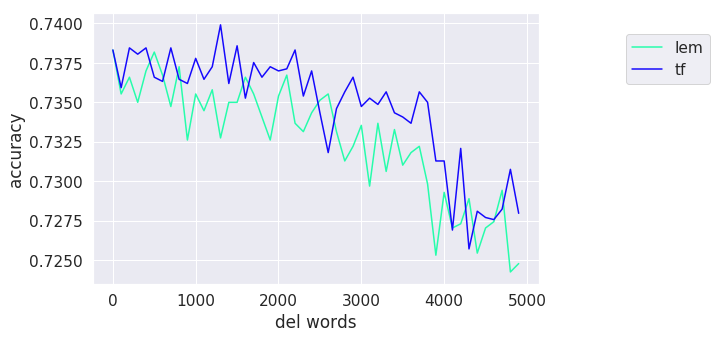

In [133]:
plt.figure(figsize=(8, 5))
plt.plot(del_w,acc_val_lem,label='lem',color=np.random.rand(3))
plt.plot(del_w,acc_val_tf,label='tf',color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("del words")
plt.ylabel("accuracy")
plt.show()

**Вывод:** Применение удалении самых частых и редких слов точность модель сначала увеличивается, а затем начинает убывать.

## удаление стоп-слов 

In [78]:
import tqdm

In [93]:
from nltk import WordNetLemmatizer
from nltk import wordnet, pos_tag

def get_wordnet_pos(treebank_tag):
    my_switch = {
        'J': wordnet.wordnet.ADJ,
        'V': wordnet.wordnet.VERB,
        'N': wordnet.wordnet.NOUN,
        'R': wordnet.wordnet.ADV,
    }
    for key, item in my_switch.items():
        if treebank_tag.startswith(key):
            return item
    return wordnet.wordnet.NOUN
def my_lemmatizer(sent):
    lemmatizer = WordNetLemmatizer()
    tokenized_sent = sent.split()
    pos_tagged = [(word, get_wordnet_pos(tag))
                 for word, tag in pos_tag(tokenized_sent)]
    return ' '.join([lemmatizer.lemmatize(word, tag)
                    for word, tag in pos_tagged])

class LemTransform(BaseEstimator, TransformerMixin):
    def transform_one_line(self,line):
        return my_lemmatizer(line)
    
    def fit_transform(self,X, y=None, **fit_params):
        if len(X[0])==1:
            return self.transform_one_line(X)
        X_trfm = []
        for line in tqdm.tqdm_notebook(X):
            X_trfm.append(self.transform_one_line(line))
        return X_trfm

lemmatizer = LemTransform()

X_train_lem, X_test_lem = lemmatizer.fit_transform(X_train),lemmatizer.fit_transform(X_test)

In [94]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vec = TfidfVectorizer(stop_words='english')

CPU times: user 0 ns, sys: 8 ms, total: 8 ms
Wall time: 8.55 ms


In [95]:
X_tf_lem = tf_idf_vec.fit_transform(X_train_lem+X_test_lem)
X_train_tf_lem = X_tf_lem[:train_size]
X_test_tf_lem = X_tf_lem[train_size:]

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

svm = SGDClassifier()

scores = cross_val_score(svm,X_train_tf_lem,y_train,cv=5)

print(scores,np.mean(scores))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


[0.8104892  0.81244484 0.81007067 0.81681416 0.81152993] 0.8122697606319441


In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vec = TfidfVectorizer(stop_words='english')

In [98]:
%%time
X_tf = tf_idf_vec.fit_transform(X_train+X_test)
X_train_tf = X_tf[:train_size]
X_test_tf = X_tf[train_size:]

CPU times: user 2.63 s, sys: 44 ms, total: 2.67 s
Wall time: 2.64 s


In [99]:
tf_idf_vocab = list(tf_idf_vec.vocabulary_.items())

len(tf_idf_vocab)

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

svm = SGDClassifier()

scores = cross_val_score(svm,X_train_tf,y_train,cv=5)

print(scores,np.mean(scores))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


[0.81313354 0.81774051 0.81448763 0.81725664 0.81374723] 0.8152731097955173


**Вывод**: удаление стоп-слов увеличило время обучения и незначительно улучшило качество модели на валидационной выборке.

## * Использование n-грамм 

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
import tqdm

svm = SGDClassifier()

In [50]:
def n_gramm_acc(n):
    tf_idf_vec = TfidfVectorizer(stop_words='english',ngram_range=(1,n))
    X_tf = tf_idf_vec.fit_transform(X_train+X_test)
    X_train_tf = X_tf[:train_size]
    X_test_tf = X_tf[train_size:]
    svm.fit(X_train_tf,y_train)
    acc=svm.score(X_test_tf,y_test)
    return acc,len(tf_idf_vec.vocabulary_)

In [53]:
n_gramm = np.arange(1,6)
res = [n_gramm_acc(n) for n in tqdm.tqdm(n_gramm)]
acc_v = [acc for acc,_ in res]
num_v = [v for _,v in res]

  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
100%|██████████| 5/5 [02:20<00:00, 28.11s/it]


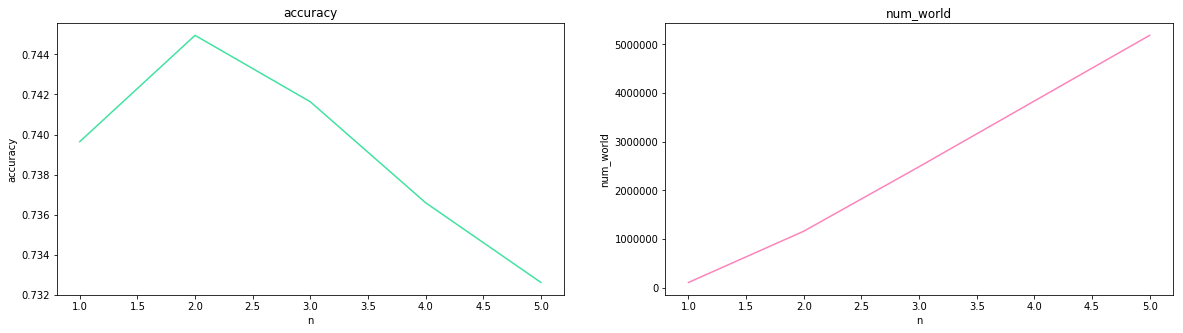

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 5))
ax1.plot(n_gramm,acc_v,color=np.random.rand(3))
ax1.set_xlabel("n")
ax1.set_ylabel("accuracy")
ax1.set_title("accuracy")
ax2.plot(n_gramm,num_v,color=np.random.rand(3))
ax2.set_xlabel("n")
ax2.set_ylabel("num_world")
ax2.set_title("num_world")
plt.show()

**Вывод**: Максимум точности на тестовой быборке достигается при использовании 1-2 граммной модели, при использовании больших n-грамм точность уменьшается.